In [13]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sys
sys.path.append('../')
import stAI

In [2]:
config_path = "./osmFISH_impute.yaml"

In [3]:
cfg = yaml.safe_load(open(config_path, 'r'))

In [4]:
model_parameters = cfg['model_parameters']
training_parameters = cfg['training_parameters']
adata_spatial = sc.read_h5ad(cfg['data_paths']['spatial_data'])
adata_rna = sc.read_h5ad(cfg['data_paths']['rna_data'])
save_dir = cfg['data_paths']['save_path']

# Train stAI Model

In [5]:
stAI.main.run_impute(model_parameters=model_parameters, training_parameters=training_parameters, adata_spatial=adata_spatial, adata_rna=adata_rna, save_dir=save_dir)

2024-06-13 22:52:59,947 - INFO - Starting training on 33 genes
2024-06-13 22:52:59,973 - INFO - Training submodel 1/5...
2024-06-13 22:52:59,975 - INFO - Training genes: ['Gad2' 'Slc32a1' 'Crhbp' 'Cnr1' 'Vip' 'Cpne5' 'Lamp5' 'Rorb' 'Syt6'
 'Kcnip2' 'Aldoc' 'Gfap' 'Serpinf1' 'Mfge8' 'Sox10' 'Plp1' 'Bmp4' 'Itpr2'
 'Anln' 'Hexb' 'Ttr' 'Foxj1' 'Vtn' 'Flt1' 'Apln' 'Acta2'], Calibration genes: ['Pthlh' 'Crh' 'Tbr1' 'Pdgfra' 'Tmem2' 'Ctps' 'Mrc1']
2024-06-13 22:53:32,475 - INFO - Epoch [50/500], Loss: 2.5497, Loss_recon: 1.2154, Loss_mmd: 0.1472, Loss_cos: 0.5322, Loss_clf: 0.6467, Loss_impute: 0.7226, Loss_genegraph: 0.3567
2024-06-13 22:53:49,805 - INFO - Epoch [100/500], Loss: 1.6418, Loss_recon: 0.6284, Loss_mmd: 0.0680, Loss_cos: 0.3454, Loss_clf: 0.3588, Loss_impute: 0.6254, Loss_genegraph: 0.2628
2024-06-13 22:54:07,009 - INFO - Epoch [150/500], Loss: 1.2419, Loss_recon: 0.3806, Loss_mmd: 0.0511, Loss_cos: 0.2451, Loss_clf: 0.2866, Loss_impute: 0.5825, Loss_genegraph: 0.2689
2024-06-13

# Find Marker Genes to Impute

In [6]:
adata_rna_processed = adata_rna.copy()
sc.pp.normalize_total(adata_rna_processed, target_sum=1e4)
sc.pp.log1p(adata_rna_processed)
sc.tl.rank_genes_groups(adata_rna_processed, groupby='celltype', method='wilcoxon')

In [8]:
shared_genes = [g for g in adata_spatial.var.index if g in adata_rna.var.index]
result = adata_rna_processed.uns['rank_genes_groups']
groups = result['names'].dtype.names


for group in ['Pyramidal', 'Oligodendrocyte']:
    print(f"Group: {group}")
    temp_marker = result['names'][group]
    marker_to_impute = [g for g in temp_marker if g not in shared_genes]
    print(f"Top 10 marker genes: {marker_to_impute[:10]}")

Group: Pyramidal
Top 10 marker genes: ['Chn1', 'Pcsk2', 'Calm1', 'Ywhah', 'Calm2', 'Nrn1', 'Sv2b', 'Ppp3ca', 'Snap25', '3110035E14Rik']
Group: Oligodendrocyte
Top 10 marker genes: ['Mbp', 'Mog', 'Cnp', 'Ugt8a', 'Mobp', 'Taldo1', 'Sept4', 'Gsn', 'Mag', 'Ermn']


In [17]:
genes_to_impute = ['Chn1', 'Pcsk2', 'Mbp', 'Mog']
marker2celltype = {
    'Chn1': 'Pyramidal',
    'Pcsk2': 'Pyramidal',
    'Mbp': 'Oligodendrocyte',
    'Mog': 'Oligodendrocyte'
}

In [11]:
res = stAI.main.impute_unmeasured_genes(genes_to_impute=genes_to_impute, model_dir="/home/gszou/stAI/demo/results/osmFISH_Zeisel", agg=True)

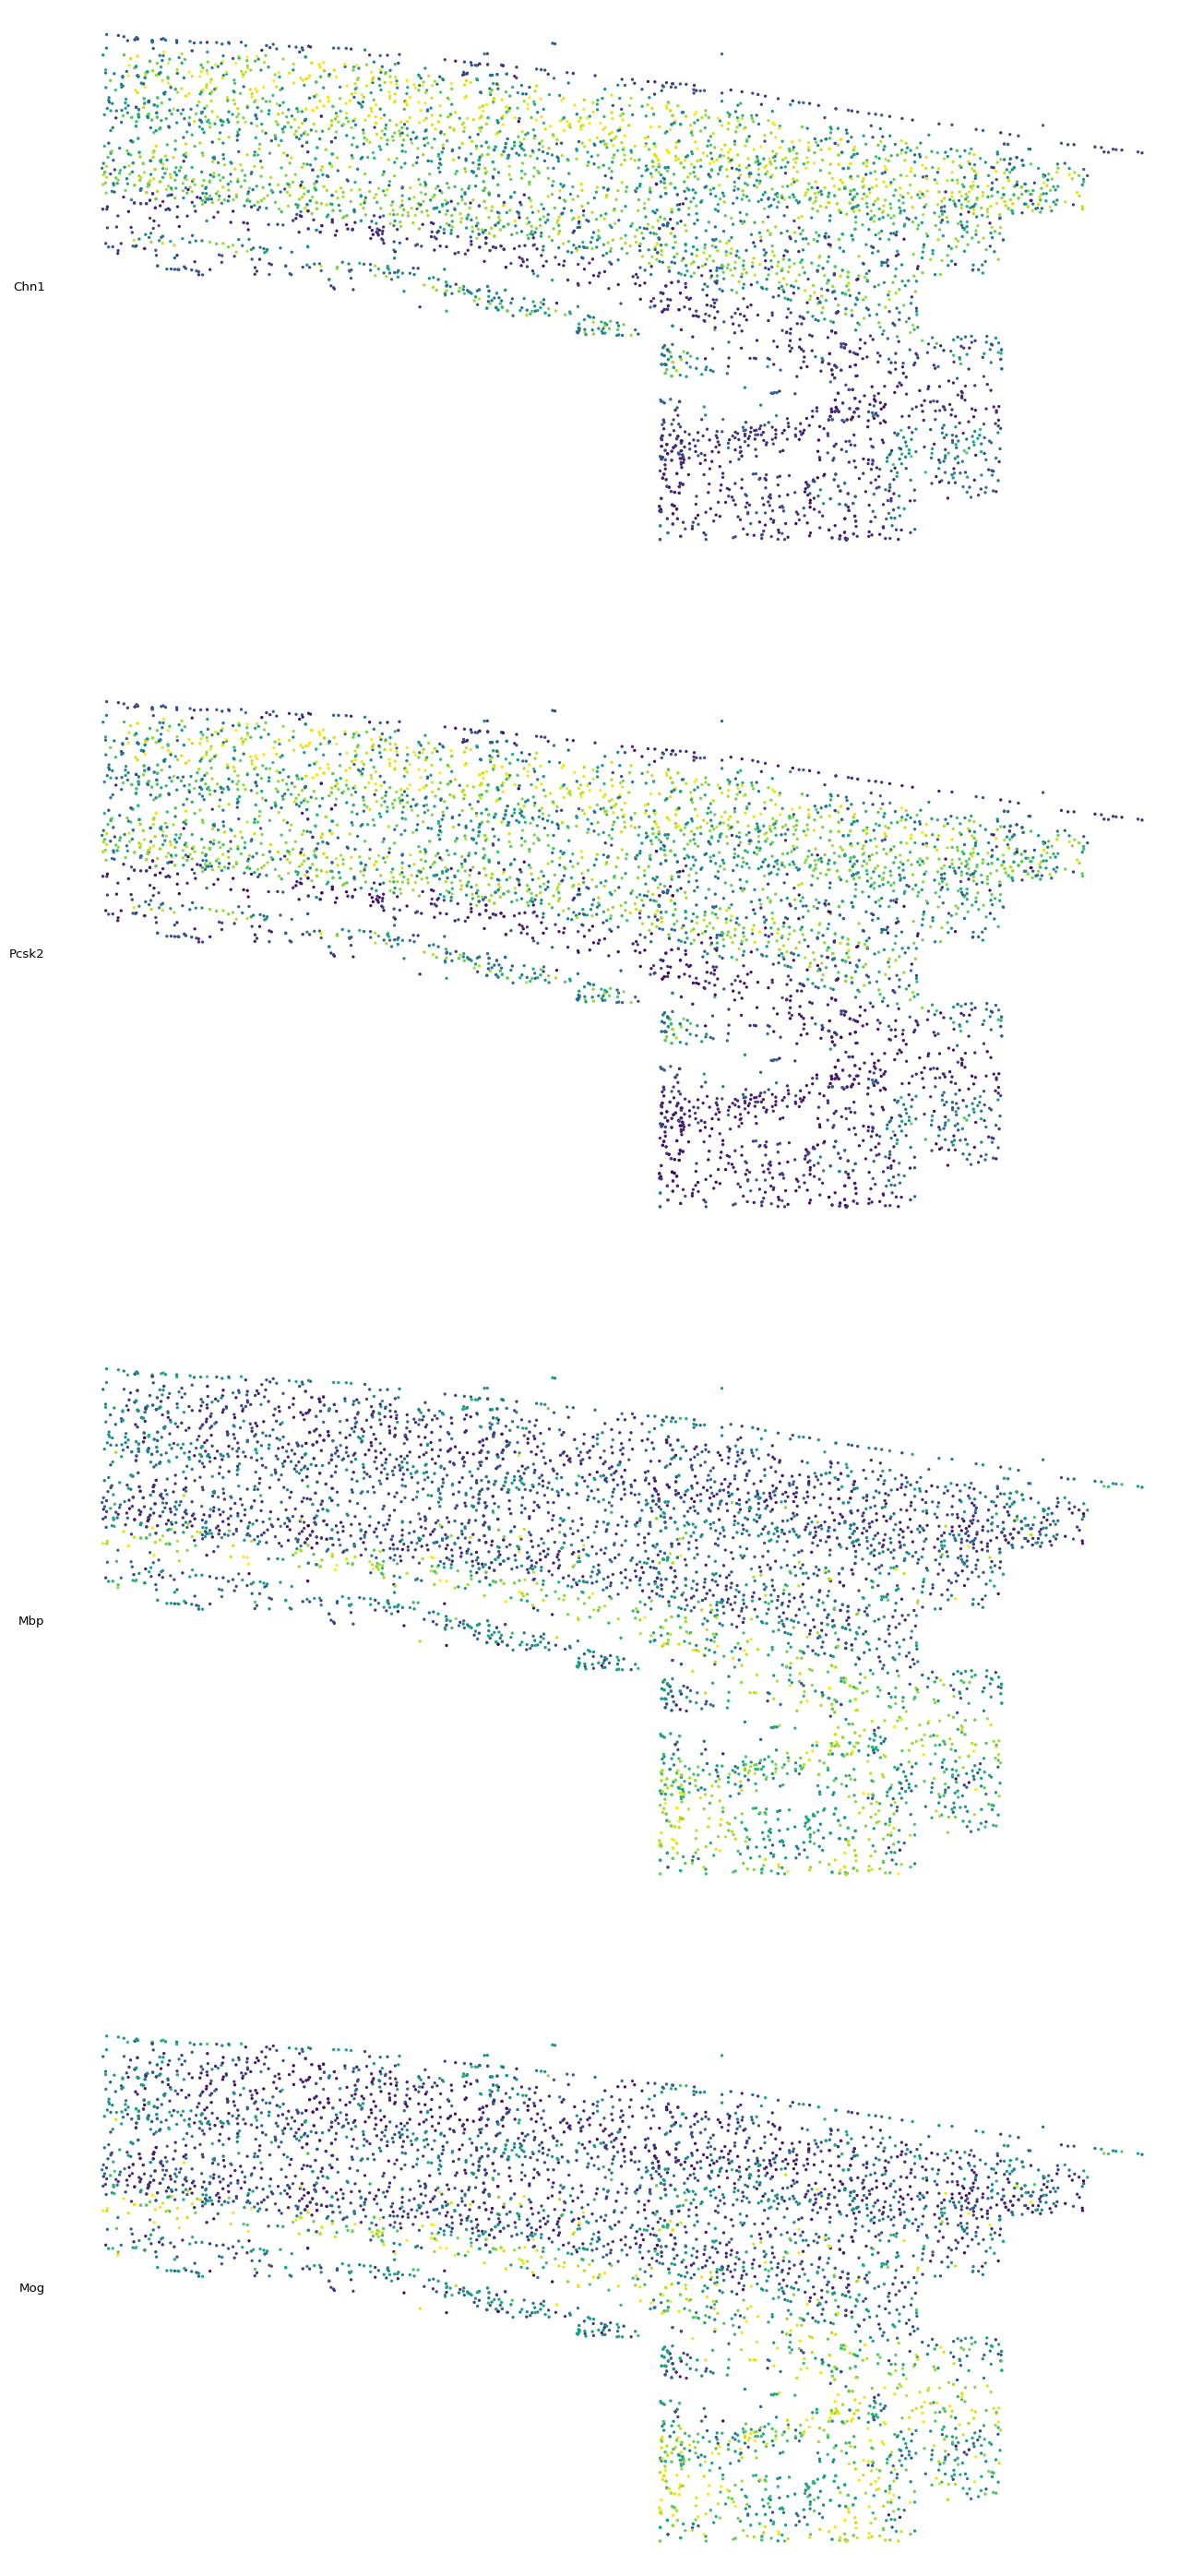

In [19]:
x = adata_spatial.obsm['spatial'][:,0]
y = adata_spatial.obsm['spatial'][:,1]
plt.style.use('default')
plt.rc('font', size=8)
fig, axes = plt.subplots(res.shape[1], 1, figsize=(16,36))
for i, g in enumerate(genes_to_impute):
    
    axes[i].axis('off')
    cmap = res[:,i]
    cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
    cmap /= cmap.sum()
    vmax = cmap.max()
    vmin = cmap.min()
    # vmax = None
    # vmin = None
    
    axes[i].scatter(x, y,s=2,c=cmap, vmax=vmax, vmin=vmin)

    axes[i].annotate(g, xy=(0, 0.5), xytext=(-axes[i].yaxis.labelpad, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='right', va='center')